In [1]:
import os
import time
import pickle
import prince
import torch
import pandas as pd
import scipy as sp  
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from transformers import BertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import  DataLoader
from tqdm.notebook import tqdm

#local codebase
from src import utils
from src import data
from src import models
from src import train

# 0. EDA
In this part, I will briefly explore the data to get a good understanding of it (essential to do preprocessing & modelling correctly)


In [2]:
#load
thermostability_df = pd.read_csv('data/thermostability.csv', encoding='unicode_escape')

In [3]:
#show head
print(thermostability_df.shape)
thermostability_df.head(10)


(261, 3)


,name,sequence,thermostability [¡C]
0,variant_1,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,55.0
1,variant_2,KETSPIPQPKTFGPLGNLPLIDKDKPTLSLIKLAEEQGPIFQIHTP...,43.0
2,variant_3,KQASAIPQPKTYGPLKNLPHLEKEQLSQSLWRIADELGPIFRFDFP...,49.0
3,variant_4,KQASAIPQPKTYGPLKNLPHLEKEQLSQSLWRIADELGPIFRFDFP...,39.8
4,variant_5,KQASAIPQPKTYGPLKNLPHLEKEQLSQSLWRIADELGPIFRFDFP...,52.9
5,variant_6,KETSPIPQPKTFGPLGNLPLIDKDKPTLSLIKLAEEQGPIFQIHTP...,48.8
6,variant_7,KQASAIPQPKTYGPLKNLPHLEKEQLSQSLWRIADELGPIFRFDFP...,45.0
7,variant_8,KETSPIPQPKTFGPLGNLPLIDKDKPTLSLIKLAEEQGPIFQIHTP...,48.3
8,variant_9,KETSPIPQPKTFGPLGNLPLIDKDKPTLSLIKLAEEQGPIFQIHTP...,61.5
9,variant_10,KETSPIPQPKTFGPLGNLPLIDKDKPTLSLIKLAEEQGPIFQIHTP...,54.6


In [4]:
#describe the df, including missing information
thermostability_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  261 non-null    object 
 1   sequence              261 non-null    object 
 2   thermostability [¡C]  261 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.2+ KB


In [5]:
#visualise, need to include='all' to get info about sequence feature
thermostability_df.describe(include='all')

,name,sequence,thermostability [¡C]
count,261,261,261.000000
unique,261,261,NaN
top,variant_1,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,NaN
freq,1,1,NaN
mean,NaN,NaN,51.821456
std,NaN,NaN,5.862987
min,NaN,NaN,36.000000
25%,NaN,NaN,47.900000
50%,NaN,NaN,50.900000
75%,NaN,NaN,55.900000


Conclusions so far:
* no data missing so far; no duplicates noticed (all categorical features are unique);
* *name* feature will not be important for modelling (can use it as index); it would be good to know whether all these variants come from one protein
* we have one categorical features and one numeric (thermostability); 
* *thermostability [¡C]* name should be changed to more programming-friendly name (i.e. no whitespace).

Questions so far:
* Are all these variants coming from originally only one protein? - the names sort of suggest that it could be all from one protein; would be good to know as then we can keep in mind the ontological/evolutionary factors


In [6]:
#clean the names & index
thermostability_df.columns = ['name', 'sequence', 'thermostability']
thermostability_df.set_index('name', inplace=True)

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9749559843734045, pvalue=0.00014907561502594278)


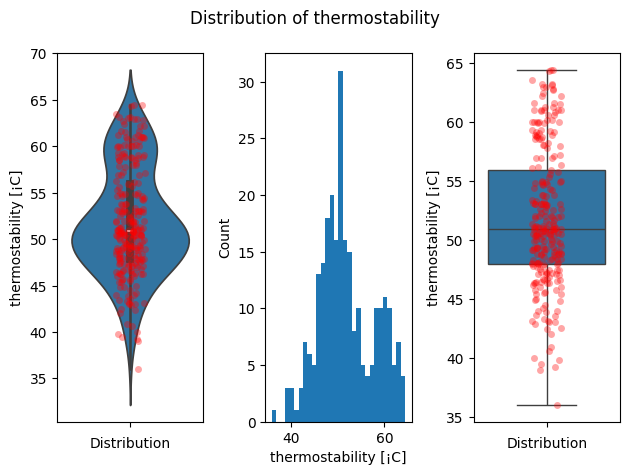

In [7]:
#Explore thermostability feature

#stats tests
print('Shapiro test for normal distribution: ', sp.stats.shapiro(thermostability_df.thermostability))

# visualisations, a few to get a better understanidng of the data
plt.subplot(1,3,1)
plt.suptitle('Distribution of thermostability')
plt.ylabel('thermostability [¡C]')
plt.xlabel('Distribution')
sns.violinplot(y='thermostability', data=thermostability_df)
sns.stripplot(y='thermostability', data=thermostability_df, color='red', alpha=0.35)
#plt.violinplot(thermostability_df.thermostability)
plt.subplot(1,3,2)
plt.hist(thermostability_df.thermostability,bins=30)
plt.xlabel('thermostability [¡C]')
plt.ylabel('Count')
plt.subplot(1,3,3)
sns.boxplot(y='thermostability', data=thermostability_df)
sns.stripplot(y='thermostability', data=thermostability_df, color='red', alpha=0.35)
plt.xlabel('Distribution')
plt.ylabel('thermostability [¡C]')
plt.tight_layout()


* There are no extreme outliers, one sequence has a very low thermostability but from visual inspection we can definitely say it's not an extreme outlier. Outlier definition by the book depends on our threshold (for example, if we decide on our threshold being 3 times std, anything outside the range of 3 * std can be considered an outlier) which **we can consult with the scientist/stakeholders (maybe only a specific range of temperatures is actually viable & stricter threshold definition is crucial)**. Either way, based on the visual inspections, there are no outliers in the data - if there are some problems with the data later down the line, I can come down & review this.

* There is nothing wrong with the distribution of the target variable, however as it is not gaussian and it's quite spread out, it will require normalization - simple MinMaxScaling should suffice. 

* The two peaks show that while we can do a random train-test split, we need to ensure that both 'peaks' are encaptured in test and train set (as train & test need to come from the same distribution). This is especially important as it's a target for our ML model

Unique lenghts of sequences in the df:  {466} 

Unique amino acids in the df:  {'T', 'M', 'W', 'S', 'C', 'P', 'V', 'E', 'R', 'G', 'F', 'H', 'Y', '-', 'N', 'D', 'A', 'L', 'I', 'Q', 'K'}
No of unique amino acids in the df:  21 

No. of sequences containing "T":  261
No. of sequences containing "M":  261
No. of sequences containing "W":  261
No. of sequences containing "S":  261
No. of sequences containing "C":  261
No. of sequences containing "P":  261
No. of sequences containing "V":  261
No. of sequences containing "E":  261
No. of sequences containing "R":  261
No. of sequences containing "G":  261
No. of sequences containing "F":  261
No. of sequences containing "H":  261
No. of sequences containing "Y":  261
No. of sequences containing "-":  109
No. of sequences containing "N":  261
No. of sequences containing "D":  261
No. of sequences containing "A":  261
No. of sequences containing "L":  261
No. of sequences containing "I":  261
No. of sequences containing "Q":  261
No. of sequen

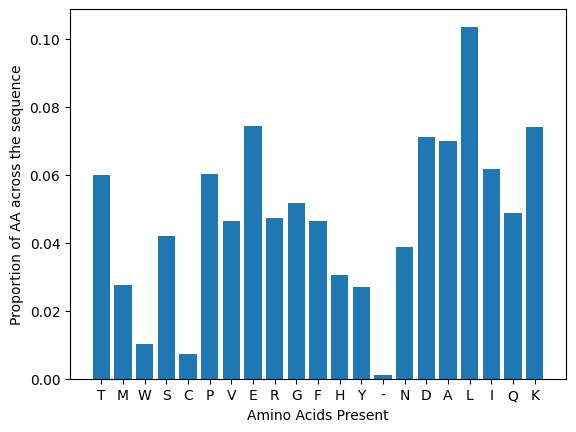

In [8]:
#Explore sequence feature
unique_aa = utils.examine_seq(thermostability_df, 'sequence')

All sequences have the same length, however this could be due to '-' being present in the sequences. While it can represent a knockout of aminoacid in the mutation (i.e. where an amino acid used to be before mutation), it might be also an artifact - need to examine it in detail.

In [9]:
#show sequences containing - 
print(thermostability_df.loc[thermostability_df.sequence.str.contains('-')].sequence.values[100]) #manually explored 0, 10, 50, 100

#seems like its at the end and middle - check if thats the case for all
artifact_positions = []
seq_of_interest= thermostability_df.loc[thermostability_df.sequence.str.contains('-')].sequence.values
for i in range(len(seq_of_interest)):
    artifact_positions.append(seq_of_interest[i].index('-'))

print('\nIndices where - is present: ',set(artifact_positions))
print('How many times present in the last position: ', artifact_positions.count(465))
print('How many times present in the middleish position: ', artifact_positions.count(231))

MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAPAGTTIVVSGHELVKEVCDEERFDKSIEGALKFVRDFAGDGLATSWTHEKNWKKAHNILLPSFSQQAMKGYHAMMVDIAVQLVQKWERLNADEHIEVPEDMTRLTLDTIGLCGFNYRFNSFYRDQPHPFITSMVRALDEAMNKLQRANPDDPAYDENKRQFQEDIKVMNDLVDKIIADRKASGEQS-DDLLTHMLNGKDPETGEPLDDENIRYQIITFLIAGHETTSGLLSFALYFLVKNPHVLQKAAEEAARVLVDPVPSYKQVKQLKYVGMVLNEALRLWPTAPAFSLYAKEDTVLGGEYPLEKGDELMVLIPQLHRDKTIWGDDVEEFRPERFENPSAIPQHAFKPFGNGQRACIGQQFALHEATLVLGMMLKHFDFEDHTNYELDIKETLTLKPEGFVVKAKSKKIPLGGIPSPST-

Indices where - is present:  {465, 231}
How many times present in the last position:  66
How many times present in the middleish position:  43


The artifact is present consistenly in the last, middle-ish or both positions. As we are working with sequence data obtained through mutations, it is very likely the '-' represents knockouts/insertions however **we should get a clarification on this from the scientists.** 

* If it is an artifact/error, we should either remove these samples (we would lose 109 samples so that's not possible in our case) or impute the amino acid (e.g. sklearn SimpleImputer based on the most common aa in this position; more viable option). 
* If it is a symbol indicating an insertion or knockout of a gene:
  * we can treat it as a feature and keep it- of course that won't represent reality well (as there are no such breaks in aa sequences) and it can impact our model (for example, if we try to predict teritary structure), however for our purpose it can be suitable as we are working with mutation data (so knockouts are expected) and we want to predict a physical propety only.
  * we can remove it as an 'artifact' - if we were to predict tertiary structure, it would be crucial to have all amino acids, thus imputation or removal of those artifacts would be more suitable. Imputation is one strategy which works well within ML realm, however we  can also remove those breaks and zero pad the sequences so they are all the same length (it's worth noting that [padding sequences is not as simple as one would think](https://www.nature.com/articles/s41598-020-71450-8) )

As I mentioned, we should get a clarificaiton and second opinion on this from the scientists who generated the data; if we had more time, we could also examine different methods. In my case though, I assume the symbol indicates an insertion/knockout and thus I will keep it & treat it as a feature (this way all sequences are the same length too, so it makes our lives & models' lives easier). If I have time I will explore this padding /imputation strategy later.


Normally, it would be also important to examine the distribution & clusterings of input data, however because the raw data is in the string format, it's not as simple. We can conduct PCA on the embeddings or one-hote encode the data and conduct MCA (PCA doesnt work well for categorical variables)) however that can be done only after preprocessing. So once we have feature representations, I will explore the sequences in greater detail.

Conclusions from exploring features:
* thermostability feature has no extreme outliers, can be normalized with usual min-max scaling.
  * we should consult stakeholders to decide what is a suitable stakeholder definition, if our assumption is OK with them 
* many sequence variants (109) have '-' symbol which is most likely a knockout/insertion but we should get clarification on this from the scientists
* we are keeping - symbol as a feature, therefore all variants have the same length, no need to pad the sequences 
* amino acids are present in different proportions in the data however each aminoacid is present in every sequence, thus it's quite diversified

# 1. Preprocessing

EDA didn't highlight any serious issues with the data, except the potential artifact & values close to extreme. Nevertheless we can start preprocessing it and converting it into ML-friendly format.

## Thoughts on Feature Representation
We need to represent the sequences in a numerical fashion. This is the most important step in this project as inappropriate representation will give us inadequate results, even if we have a great model (thats the case for all ML project, bad data= bad predictions).

Some ways to do it:
* one-hot encoding - the simplest & most baseline method. Quite memory inefficient, no contextual information, and creates a very sparse matrix (21 aa * 461 spots * 260 samples) filled with 0/1. However it could be a good baseline for the project to see how other methods improve our workflow (it's a common approach for working with sequences too, as far as Im aware).
* embeddings - more advanced than one-hot encoding, falls under word2vec umberalla; memory efficient and can be contextual (very contextual or just a little - depends how deep & complicated we want to go). We can train an embedding neural network from scratch using our data only or use a pre-trained embedding models/transformers such as ([bioBERT](https://academic.oup.com/bioinformatics/article/36/4/1234/5566506) or [representation embeddings](https://academic.oup.com/bioinformatics/article/34/15/2642/4951834) ). 
* SMILES - an 'extra' way but could be interesting to examine it. Molecules (including peptides) can be converted into SMILES and represented as graphs, which can be accepted by graph-like models (such as [chemprop](https://github.com/chemprop/chemprop)). For this we would likely need GPUs though (protein representations in SMILES will be massive)

In every ML project, it is important to have a baseline to benchmark your progress - therefore I will initially start with one-hot encoding (even though I expect it to be the least effective), and then will progress to embeddings (maybe SMILES too if time permits but it's unlikely to be efficient in our case). 

It's important to note that we are working with highly dimensional data in this case as once we have embeddings/one-hot encodings, we will have way more features than samples, which is far from ideal scenario (usually we want to have 5*more samples than features). Although we can start working with highly dimensional data but as we progress with the project further, it will be crucial to reduce the number of features (can be done through feature importance filtering, feature engineering, compact embeddings - many approaches out there to be examined).  

## Thoughts on train-test split

We don't have huge amounts of data but it should suffice. To make a predictive model, we need to have a good train-test split (in ideal scenario we would have a separate, unseen data that we can use for testing, but thats not the case) and take some factors into account:

* Distribution of train and test data should be the same - challenging to examine with sequence data, we can look into it more once we have suitable embeddings; we dont need to worry about distribution of input data when we have one-hot encoding (as we have categorical variables). For target data, we need to ensure same distribution through normalization & good split
* Not-so randomized split - rather than randomly splitting the data for train-test, it is often better to do a grouped train-test split if we have enough information available. In this case, if we knew that variants come from originally different proteins, we could group them by 'parent' protein & divide them based on that (this way we would have an 'unseen' parent protein & its mutation in the test set to see if our model generalizes well & recognizes important patterns). **It would be beneficial to ask people who produced the data for more information / metadata so that we can do grouped split**.  As of now, we dont have that information so we will just do controlled & randomised train-test split 

We can do 80-20 train-test split (taking into account the mentioned factors), and conduct 5-fold CV on the train set to ensure good generelizability w/o information leakage. 

## Thoughts on standardisation
We need to normalize our target feature (thermostability temp) as ML or statistical models might malfunction and not predict properly due to large differences/outliers. As the target feature is not normally distributed and there are no extreme outliers, we can use min-max scaling (z-score normalization could also work but min-max is safer for non-gaussian distribution). 

Normalization of the sequences is not very straightforward as its raw format is encoded as text. We don't need to normalize one-hot encoded data and dont need to normalize embedded data (model embedding should do it for us, however this could differ from model-to-model). Furthermore, as sequences are of the same lengths (thanks to '-' knockout/insertion symbol, which we treat as a feature) we don't need to do padding etc (unless we decide to work with SMILES, then we will need to remove '-' symbols).

## Feature Representation

In [10]:
all_aa = ''.join(thermostability_df.sequence)
unique_aa= list(set(all_aa))

one_hot_df = data.one_hot(unique_aa, thermostability_df.sequence.values)
print('Shape of one-hot encoded sequences', one_hot_df.shape)
print('No. of samples ', one_hot_df.shape[0]) 
print('No. of positions ', one_hot_df.shape[1]) 
print('no. of unique amino acids ', one_hot_df.shape[-1]) 
one_hot_df

Shape of one-hot encoded sequences (261, 466, 21)
No. of samples  261
No. of positions  466
no. of unique amino acids  21


array([[[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

As we can see the data is very sparse & only contain 1 or 0, we can also see the high-dimensionality of the data - this is something we need to address later on but it can be a good baseline.

We can examine MCA now 

In [11]:
#choosing 20 as an arbitrary number, will give us a good overall picture
mca =prince.MCA(20)
mca.fit(pd.DataFrame(one_hot_df.reshape(261,-1)))
transformed = mca.transform(pd.DataFrame(one_hot_df.reshape(261,-1)))
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.007,14.27%,14.27%
1,0.006,13.01%,27.29%
2,0.005,9.57%,36.85%
3,0.004,8.22%,45.07%
4,0.004,8.03%,53.10%
5,0.004,7.15%,60.25%
6,0.003,6.17%,66.43%
7,0.003,5.37%,71.80%
8,0.002,5.02%,76.81%


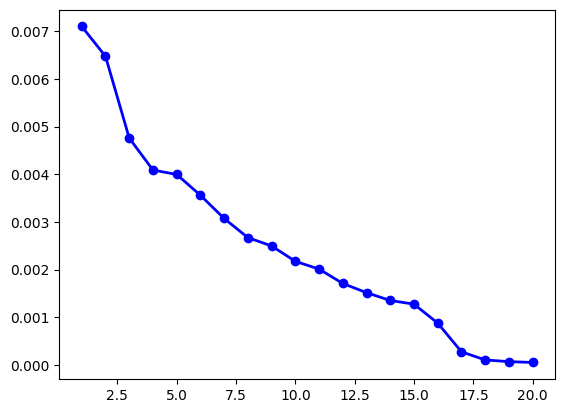

In [12]:
MC_values = np.arange(mca.n_components) + 1
plt.plot(MC_values, mca.eigenvalues_, 'o-', linewidth=2, color='blue')

The first 10 eigenvalues / components explain 80% of data; we can also clearly see which components are the most important in terms of data variation. This is a good sign as it means that our features 'cluster' well into components which we could potentially use for modelling (it's not the best idea for regression, better applied to classification problems, however when we are dealing with highly dimensional data, it is one of potential solutions).

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9151283680127257, pvalue=5.1477448453089945e-11)


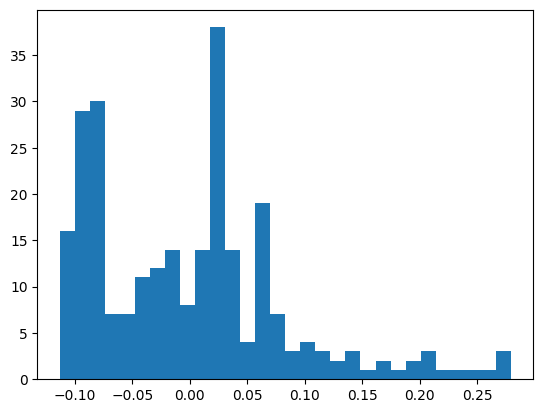

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9237091371277799, pvalue=2.5820175381220437e-10)


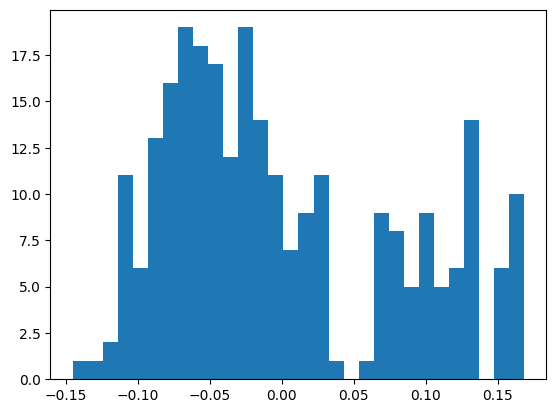

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9730798634633724, pvalue=7.675232689249116e-05)


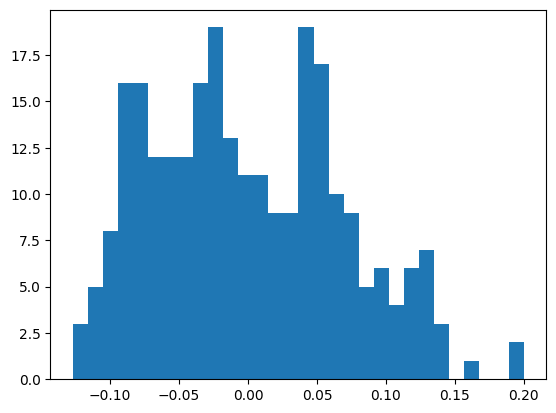

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9880545679212877, pvalue=0.029318798286517022)


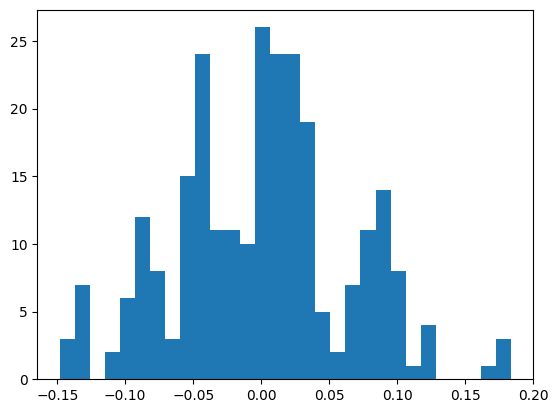

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9859330339698489, pvalue=0.01154143797459123)


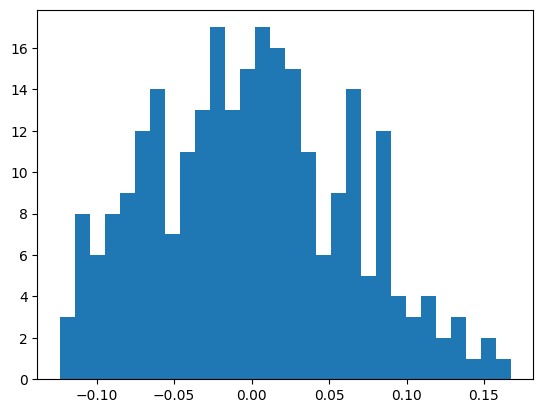

Shapiro test for normal distribution:  ShapiroResult(statistic=0.985900966785952, pvalue=0.011382096574144584)


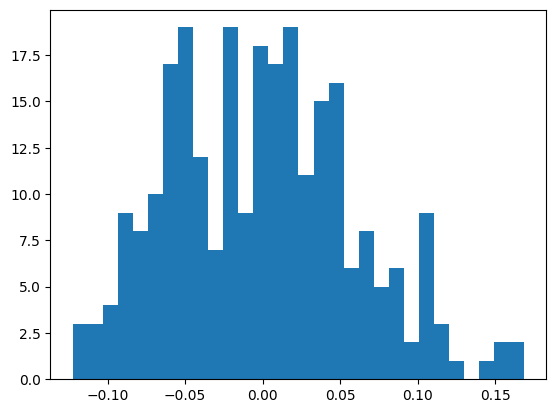

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9881705740822736, pvalue=0.03087073817187488)


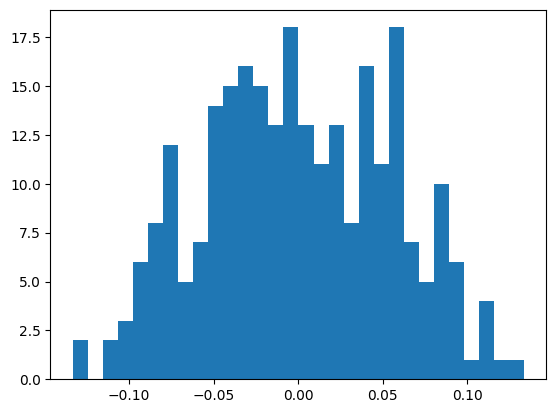

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9858591112025201, pvalue=0.011177527381831903)


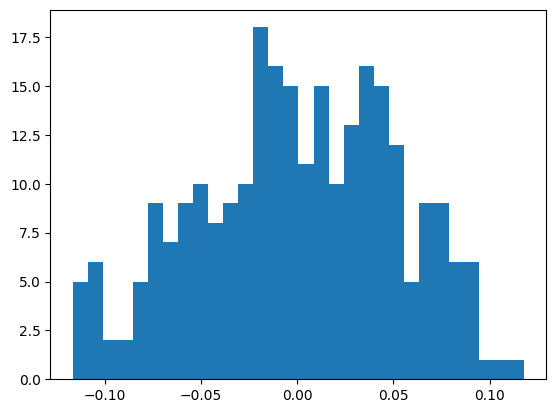

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9879711368718923, pvalue=0.02825198391235439)


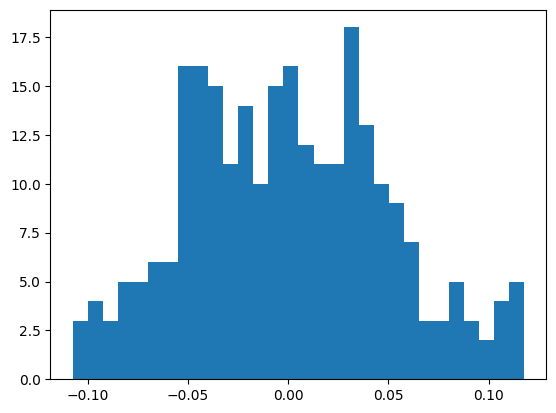

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9974802692171212, pvalue=0.9588436401861733)


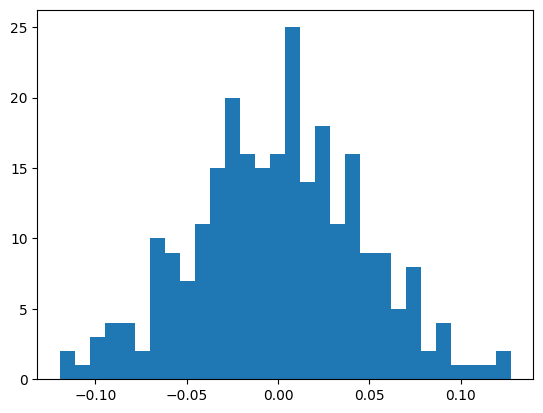

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9966661094859692, pvalue=0.8609552858693073)


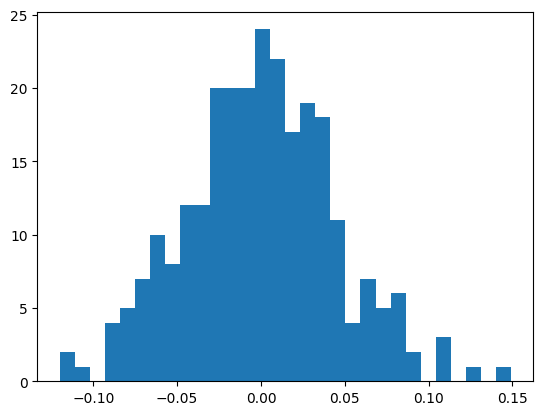

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9931227925732969, pvalue=0.2730623261084927)


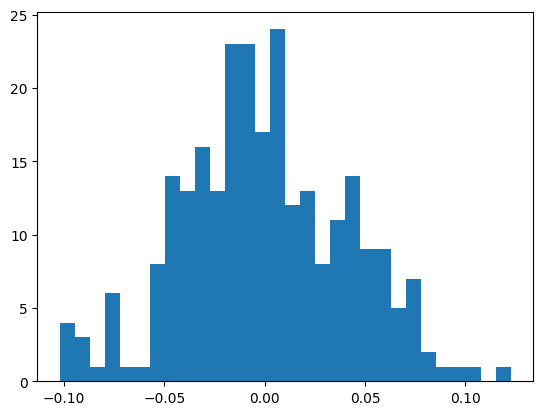

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9828916771536262, pvalue=0.0031818823304638737)


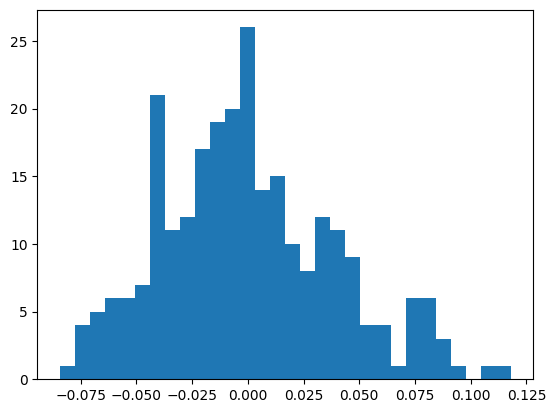

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9046338194265131, pvalue=8.232259130318031e-12)


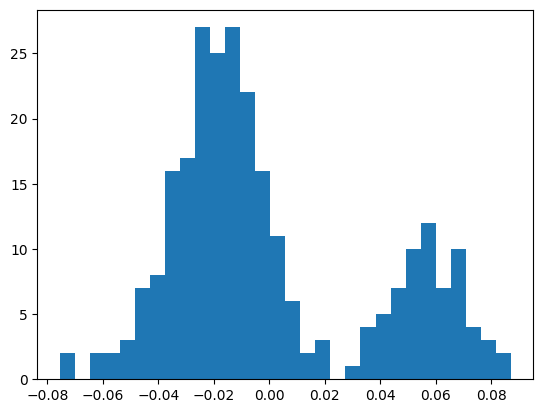

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9276000656824541, pvalue=5.575904733155133e-10)


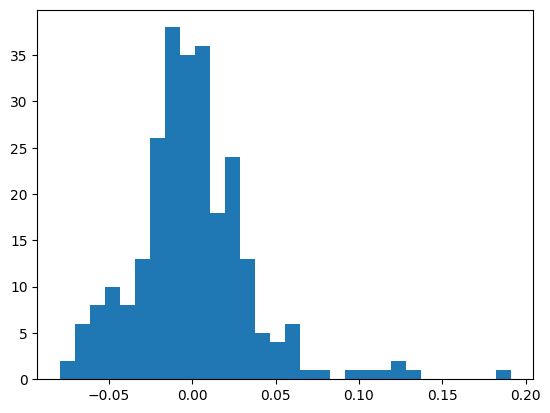

Shapiro test for normal distribution:  ShapiroResult(statistic=0.9279199947703959, pvalue=5.947198821980151e-10)


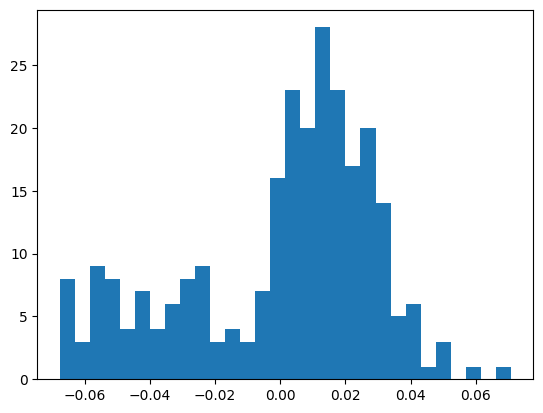

Shapiro test for normal distribution:  ShapiroResult(statistic=0.4584889287753512, pvalue=2.061842508757394e-27)


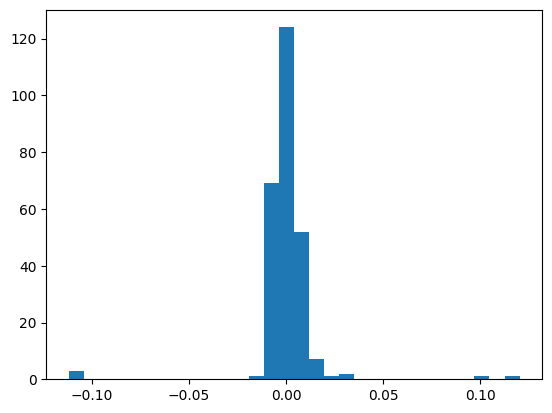

Shapiro test for normal distribution:  ShapiroResult(statistic=0.4484458049188814, pvalue=1.2927357361047284e-27)


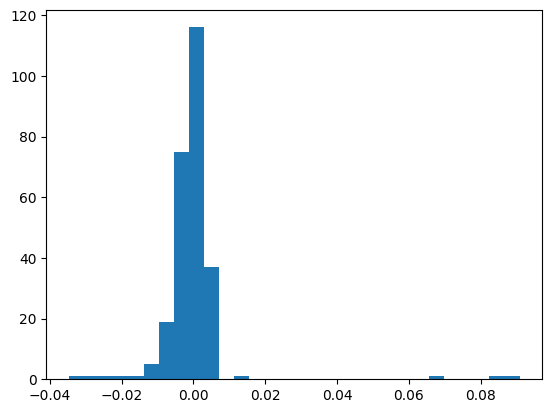

Shapiro test for normal distribution:  ShapiroResult(statistic=0.4787112575149113, pvalue=5.3906826843538405e-27)


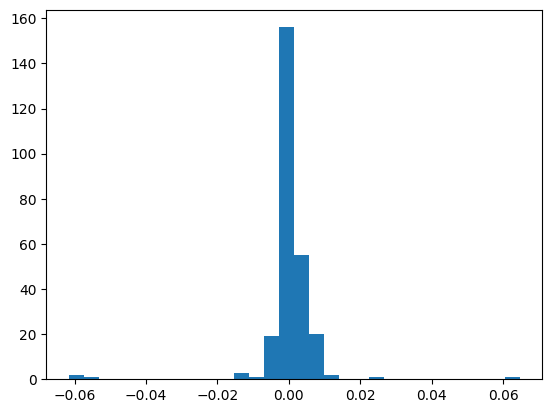

Shapiro test for normal distribution:  ShapiroResult(statistic=0.3406653474040423, pvalue=1.2621151481603933e-29)


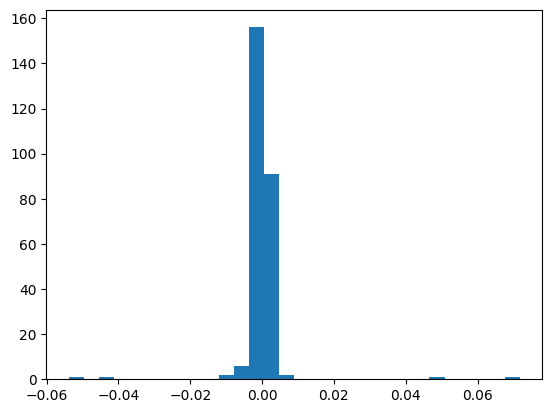

In [12]:
for i in range(len(transformed.columns)): 
    print('Shapiro test for normal distribution: ', sp.stats.shapiro(transformed.iloc[:,i]))
    plt.hist(transformed.iloc[:,i],bins=30)
    plt.show()

We can see that the components are coming from different features, so they will require normalizaton if we decide to use them for modelling (again, not the best solution)

Now about embeddings:

Embeddings of the sequence data should be much more efficient but also complex; there are several ways to obtain them, the ones I am considering are the following:
* One would be to obtain them 'from scratch' (i.e. develop a neural network for embeddings, for example [CBOW](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html) from word2vec umbrella) however it will require a lot of optimization to find the best solution (deciding on the tokens/k-mers is already a complicated area). However, it would be good for our purpose.
  
* Second one would be to use pre-trained transformers / embedding models that were trained on a large amount of sequence data. However, there are very many models out there - such as ([bioBERT](https://academic.oup.com/bioinformatics/article/36/4/1234/5566506) or [representation embeddings](https://academic.oup.com/bioinformatics/article/34/15/2642/4951834)). Choosing the right one would be also quite time-consuming (and it's also possible we wouldnt find the right one and would need to fine-tune it)

Because of time constraints, I will use the fastest approach which is using a protBert from Hugging Face. It is a BERT transformer fine-tuned for protein sequences, reported in the [literature](https://doi.org/10.1101/2020.07.12.199554) and available on hugging face, so it should be relatively quick to implement

In [64]:
#importing a bert transformer for protein sequences 
#note that sometimes hugging face server might not work and you might
#not be able to downlaod the bert - their severs were off when trying to reproduce the notebook, hence the cell is displaying an error
#(it's not such a big deal as the embeddings didn't work out in the first place, however I could download the model)
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert") 
model = BertModel.from_pretrained("Rostlab/rot_bert")

## We probably dont want - symbols when generating embeddings - cleaning required
thermostability_df_clean = utils.clean_artifacts(thermostability_df)
embedded_seq = data.embed_seq_wrapper(thermostability_df_clean.sequence, model, tokenizer)

print('Shape of embeddings: ', embedded_seq.shape)
print('Token no: ', embedded_seq.shape[1])
print('Embeddings shape: ', embedded_seq.shape[2])
embedded_seq

OSError: Rostlab/rot_bert is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

I have decided to use the default settings for tokenization & modelling; 3 tokens seems a bit small for sequences that are 461 aa long, but maybe it's enoguh (I don't have enough experience with sequence data to say). However it seems like all embeddings are the same so something is definitely wrong.



In [75]:
(embedded_seq[1]==embedded_seq[0]).all()

True

My intuition tells me there is something wrong with the tokenizer (as three tokens is probably not enough to capture 461 aa long sequences). If time permits, I will try troubleshooting/customizing tokenizer so it captures more data. 

It's worth noting that it **could be beneficial to consult the tokenization/representation with the stakeholders - while we can follow our intuition and see what works well, tokenization is the most powerful when combined with domain knowledge**. For example if we expect certain patterns that are 3 aa long (let's say LKL) to be the factor for high thermostability, we should set our tokens to be 3-symbols long with stride=0. 

## Train-test-split & Normalization

We will go by default 80:20 train-test ratio (train will be further divded for cross-validation later on). As mentioned before, we should make sure the train and test come from the same distribution, so we should control our split (i.e. run some tests later). We also need to normalize our data - we scale the MinMaxScaler based on the train target and then apply it to the test target

In [18]:
#split
y = thermostability_df[['thermostability']]
X = one_hot_df

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

#scale
scaler = MinMaxScaler()
scaler.fit(y_train)
y_train_norm = scaler.transform(y_train.values)
y_test_norm = scaler.transform(y_test.values)

c:\Users\kjvf934\repo\ml_challenge\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\kjvf934\repo\ml_challenge\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


KstestResult(statistic=array([0.10585994]), pvalue=array([0.68522612]), statistic_location=array([0.36619718]), statistic_sign=array([-1.]))


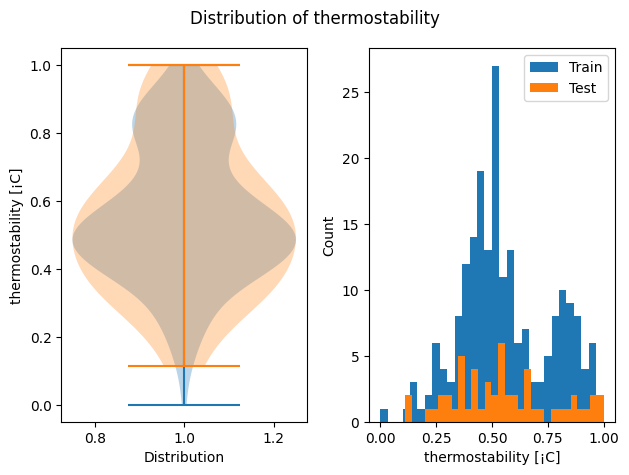

In [19]:
#check distributionf of y, if they come from the same distribution post-normalization
print(sp.stats.kstest(y_train_norm, y_test_norm))

# visualisations
plt.subplot(1,2,1)
plt.suptitle('Distribution of thermostability')
plt.ylabel('thermostability [¡C]')
plt.xlabel('Distribution')
plt.violinplot(y_train_norm,)
plt.violinplot(y_test_norm)
plt.subplot(1,2,2)
plt.hist(y_train_norm,bins=30, label='Train')
plt.hist(y_test_norm,bins=30, label='Test')
plt.xlabel('thermostability [¡C]')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()


According to the KS test, the target for test & train come from the same distribution, we should also check if the same case is for input (not really possible when one-hot encoded, once we have good embeddings we can do it).

# 3. Data Modelling

When modelling the data, it is important to have a baseline/simple reference model for a few reasons:
* To track our progress from baseline to more complex models (helps with seeing whether we are actually headed in the right direction)
* Helps with benchmarking other models
* If we work with this type of data & problem for the first time, maybe simple linear models are enough and there is no need for complex neural networks? We shouldn't implement complex & computationally expensive models if simple models & more explainable have the same performance (which is often the case - as pointed out [here](https://www.nature.com/articles/s41598-023-28421-6))

Therefore, I will first train a Linear regression to check its performance against 1) One-hot encoded data 2) Embedded Data (if time permits). I will first run it w/o cross-validation to see how it performs on its own, then cross-validation to see how it generalizes.

I will use MSE as a main metric of choice ('optimizing' metric, typical choice for regression & can be also used as loss in neural networks). This is my own choice however it is always **good to consult such decisions with stakeholders (especially when dealing with classification problems)**

Note that because we normalized the target variables, the predictions are also going to be normalized; to assess the performance I will compare the scaled predictions with scaled target variable however for inference & production it is crucial to unscale the target variables

In [20]:
#create models dir
os.system('mkdir models')

#First check how the model is doing w/o validation (if it works)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#instantiate
reg = LinearRegression()

#train - note that we need to reshape as sklearn only accepts two dimensional arrays
reg.fit(x_train.reshape(208,-1), y_train_norm.reshape(-1,1))

#save
import pickle
with open('models/baseline_regression.pkl', 'wb') as file:
    pickle.dump(reg, file)

#test on the train set - see if overfitting
y_pred_norm = reg.predict(x_train.reshape(x_train.shape[0],-1))
print('Performance on the train set (sanity & overfit check)', mean_squared_error(y_train_norm, y_pred_norm))
print('Performance on the train set (sanity & overfit check), r2_score',r2_score(y_train_norm, y_pred_norm))

Performance on the train set (sanity & overfit check) 0.006316082787730564
Performance on the train set (sanity & overfit check), r2_score 0.8440482137023023


While model's performance on the train set is not very informative or indicative of model performance, it shows that model was successfuly fit & data can be modelled. Let's explore cross-validation now to see how well it actually performs

In [21]:
torch.manual_seed(0)

reg=LinearRegression()
predictions, real = train.train_sklearn_with_cv(reg,x_train.reshape(208,-1), y_train_norm.reshape(-1,1), cv=5)

0
MSE:  8.505851250054329e+21
R2:  -1.7548089693316034e+23
1
MSE:  2.0902691703076744e+21
R2:  -7.770548323280202e+22
2
MSE:  4.934044692717546e+19
R2:  -9.416943724932627e+20
3
MSE:  9.053133412908799e+20
R2:  -3.1797950791943146e+22
4
MSE:  2.5674715949566098e+22
R2:  -6.003003761551459e+23
[8.505851250054329e+21, 2.0902691703076744e+21, 4.934044692717546e+19, 9.053133412908799e+20, 2.5674715949566098e+22]


This is why cross validation is quite important - without using test set, we can quickly see that something is wrong as good results are close to 0 (or 1 in case of R2). This might mean that data is very difficult to model for linear regression (could be the case for non-linear models) or there is something wrong with the data. Let's do some quick error analysis

In [23]:
#check predictions for the first fold

for i in range(15):
    print('Pred Value: ',predictions[0][i], 'Real Value: ', real[0][i])

Pred Value:  [0.5078125] Real Value:  [0.46830986]
Pred Value:  [0.09863281] Real Value:  [0.24647887]
Pred Value:  [0.17285156] Real Value:  [0.42253521]
Pred Value:  [0.94921875] Real Value:  [1.]
Pred Value:  [0.68847656] Real Value:  [0.64788732]
Pred Value:  [0.67871094] Real Value:  [0.71478873]
Pred Value:  [0.55664062] Real Value:  [0.51056338]
Pred Value:  [0.65039062] Real Value:  [0.76760563]
Pred Value:  [0.45117188] Real Value:  [0.48943662]
Pred Value:  [-9.06073656e+10] Real Value:  [0.1056338]
Pred Value:  [0.29003906] Real Value:  [0.44014085]
Pred Value:  [0.60058594] Real Value:  [0.58098592]
Pred Value:  [0.56933594] Real Value:  [0.73591549]
Pred Value:  [0.38964844] Real Value:  [0.46126761]
Pred Value:  [0.32910156] Real Value:  [0.24295775]


From the quick look at the predictions, it seems like majority of predictions look OK but there are some which are strange (i.e. [-9.06073656e+10] which is massively exaggerated - it's not possible that a protein would have such low thermostability).

If it's due to an outlier, using generalized linear regression would solve this issue pretty easily - let's quickly try Ridge Regression

In [24]:
torch.manual_seed(0)

reg=Ridge()
predictions, real = train.train_sklearn_with_cv(reg,x_train.reshape(208,-1), y_train_norm.reshape(-1,1), cv=5)

0
MSE:  0.011965500551456102
R2:  0.753144428782442
1
MSE:  0.00900050735037302
R2:  0.6654073155094296
2
MSE:  0.011881321610923697
R2:  0.7732372851161377
3
MSE:  0.009330304561376852
R2:  0.6722852168582168
4
MSE:  0.006924416429773857
R2:  0.8381002619225328
[0.011965500551456102, 0.00900050735037302, 0.011881321610923697, 0.009330304561376852, 0.006924416429773857]


In [25]:
#check predictions for the first fold
for i in range(15):
    print('Pred Value: ',predictions[0][i], 'Real Value: ', real[0][i])

Pred Value:  [0.51567956] Real Value:  [0.46830986]
Pred Value:  [0.15241276] Real Value:  [0.24647887]
Pred Value:  [0.17774436] Real Value:  [0.42253521]
Pred Value:  [0.93569067] Real Value:  [1.]
Pred Value:  [0.7008131] Real Value:  [0.64788732]
Pred Value:  [0.67663606] Real Value:  [0.71478873]
Pred Value:  [0.55686855] Real Value:  [0.51056338]
Pred Value:  [0.67311853] Real Value:  [0.76760563]
Pred Value:  [0.48474864] Real Value:  [0.48943662]
Pred Value:  [0.40249675] Real Value:  [0.1056338]
Pred Value:  [0.36220377] Real Value:  [0.44014085]
Pred Value:  [0.58417367] Real Value:  [0.58098592]
Pred Value:  [0.55677048] Real Value:  [0.73591549]
Pred Value:  [0.43877466] Real Value:  [0.46126761]
Pred Value:  [0.34981839] Real Value:  [0.24295775]


Ridge Regression does a really good job in the cross validation, lets check how it performs on the test set 

In [26]:
predictions =reg.predict(x_test.reshape(x_test.shape[0],-1))
real = y_test_norm.reshape(-1,1)

print('Performance on the test set (mse)', mean_squared_error(real, predictions))
print('Performance on the test set (r2)', r2_score(real, predictions))
#check predictions
for i in range(len(predictions[0])):
    print('Pred Value: ',predictions[0][i], 'Real Value: ', real[0][i])

Performance on the test set (mse) 0.008780365048569983
Performance on the test set (r2) 0.824693489716469
Pred Value:  0.4150037380722108 Real Value:  0.39084507042253525


In [27]:
#check predictions
for i in range(15):
    print('Pred Value: ',predictions[i], 'Real Value: ', real[i])

Pred Value:  [0.41500374] Real Value:  [0.39084507]
Pred Value:  [0.53248672] Real Value:  [0.41197183]
Pred Value:  [0.47199435] Real Value:  [0.35211268]
Pred Value:  [0.50731051] Real Value:  [0.47535211]
Pred Value:  [0.41359734] Real Value:  [0.37676056]
Pred Value:  [0.654739] Real Value:  [0.66901408]
Pred Value:  [0.309175] Real Value:  [0.28873239]
Pred Value:  [0.29636348] Real Value:  [0.28169014]
Pred Value:  [0.66294556] Real Value:  [0.65492958]
Pred Value:  [0.5139411] Real Value:  [0.48943662]
Pred Value:  [0.44354885] Real Value:  [0.47183099]
Pred Value:  [0.60613364] Real Value:  [0.55633803]
Pred Value:  [0.80926681] Real Value:  [0.92957746]
Pred Value:  [0.88187767] Real Value:  [0.96830986]
Pred Value:  [0.74400671] Real Value:  [0.77464789]


The model seems to have very good performance and seems to generalize pretty well. There is no extreme predicted values being present - this is quite promising in terms of performance but also indicates there can be something wrong with the data (we can try removing the 'borderline' outliers and examine the models again as the next step). Lets explore another type of model which should be unaffected by the outliers - neural networks

## Neural Network

Now that we have a baseline model & generalized Ridge Regression, we can train more complex models to see if they also perform badly for certain samples etc or if their performance overall is much better than Ridge. 

If I had more time, I would explore some classical ML models like random forests, SVM, or even boosting trees (XGBoost) however in this case I will train neural network with pytorch framework, as they tend to work very well with non-linear problems (which can be the case here) or sparse data (which is the case for one-hot encoding).

As before, I will first train the it on its own (with manually chosen validation data, required for any neural network) to see how it performs, then will use cross-validation on the full train set to see how well it generalizes

In [53]:
#divide train into val & train subsets 
x_train_v2, x_val, y_train_v2, y_val = train_test_split(x_train,y_train, test_size=0.2, random_state=42)

#scale
scaler = MinMaxScaler()
scaler.fit(y_train_v2)
y_train_v2_norm = scaler.transform(y_train_v2.values)
y_val_norm = scaler.transform(y_val.values)

#set up datasets and dataloader
train_dataset = data.SequenceDataset(x_train_v2, y_train_v2_norm)
val_dataset = data.SequenceDataset(x_val, y_val_norm)

#we are using relatively large batch size to get a 'full picture' of the data
#it will be worth revisiting later on & optimizing it to get the best model performance
train_dataloader = DataLoader(train_dataset, batch_size=64)
val_dataloader = DataLoader(val_dataset, batch_size=8)


c:\Users\kjvf934\repo\ml_challenge\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\kjvf934\repo\ml_challenge\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\kjvf934\repo\ml_challenge\.venv\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Train MSE  0.10902828723192215


  0%|          | 0/6 [00:00<?, ?it/s]

Val MSE  0.14056994020938873
2


  0%|          | 0/3 [00:00<?, ?it/s]

Train MSE  0.06007283553481102


  0%|          | 0/6 [00:00<?, ?it/s]

Val MSE  0.10643921047449112
3


  0%|          | 0/3 [00:00<?, ?it/s]

Train MSE  0.07861015200614929


  0%|          | 0/6 [00:00<?, ?it/s]

Val MSE  0.2634006142616272
4


  0%|          | 0/3 [00:00<?, ?it/s]

Train MSE  0.0726395845413208


  0%|          | 0/6 [00:00<?, ?it/s]

Val MSE  0.03484001010656357
5


  0%|          | 0/3 [00:00<?, ?it/s]

Train MSE  0.027868105098605156


  0%|          | 0/6 [00:00<?, ?it/s]

Val MSE  0.0033599333837628365
6


  0%|          | 0/3 [00:00<?, ?it/s]

Train MSE  0.0656183734536171


  0%|          | 0/6 [00:00<?, ?it/s]

Val MSE  0.02304399199783802
7


  0%|          | 0/3 [00:00<?, ?it/s]

Train MSE  0.038351643830537796


  0%|          | 0/6 [00:00<?, ?it/s]

Val MSE  0.008983476087450981
8


  0%|          | 0/3 [00:00<?, ?it/s]

Train MSE  0.03700414299964905


  0%|          | 0/6 [00:00<?, ?it/s]

Val MSE  0.005072949454188347
9


  0%|          | 0/3 [00:00<?, ?it/s]

Train MSE  0.02829933539032936


  0%|          | 0/6 [00:00<?, ?it/s]

Val MSE  0.01343795657157898
10


  0%|          | 0/3 [00:00<?, ?it/s]

Train MSE  0.036069441586732864


  0%|          | 0/6 [00:00<?, ?it/s]

Val MSE  0.010447056964039803
Early stopping after 10 epochs.
[0.10902828723192215, 0.06007283553481102, 0.07861015200614929, 0.0726395845413208, 0.027868105098605156, 0.0656183734536171, 0.038351643830537796, 0.03700414299964905, 0.02829933539032936, 0.036069441586732864]
[0.14056994020938873, 0.10643921047449112, 0.2634006142616272, 0.03484001010656357, 0.0033599333837628365, 0.02304399199783802, 0.008983476087450981, 0.005072949454188347, 0.01343795657157898, 0.010447056964039803]


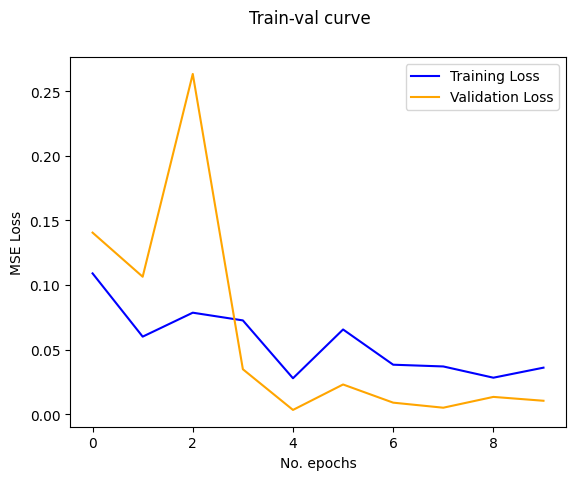

Training time:  6.253119230270386


In [54]:
#I am choosing 30 epochs; it's probably too many for such small dataset but early stopping should help prevent overfitting
# learning rate is 0.001 as a starting point (better start higher, but not too high so to avoid overshooting)

trainer = train.ThermoNetTrainer(train_dataloader, val_dataloader, lr=0.001, epochs=30)
start = time.time()
trainer.train()
print('Training time: ', time.time() - start)

In [55]:
# for consistency, we will check how it performs on the train set (not very informative but good to check overall performance)
score_mse=[]
for inputs, labels in tqdm(train_dataloader):
    y_pred = trainer.predict(inputs)
    score_mse.append(mean_squared_error(y_pred, labels))
print(np.mean(score_mse))
print(r2_score(y_pred, labels))

  0%|          | 0/3 [00:00<?, ?it/s]

0.009730197
0.7590632951593628


In [56]:
for i in range(15):
    print(y_pred[i], labels[i])

tensor([0.5248]) tensor([0.6250])
tensor([0.6596]) tensor([0.5368])
tensor([0.4634]) tensor([0.5257])
tensor([0.4723]) tensor([0.3566])
tensor([0.4621]) tensor([0.3897])
tensor([0.4340]) tensor([0.3125])
tensor([0.7526]) tensor([0.8456])
tensor([0.5326]) tensor([0.5515])
tensor([0.8776]) tensor([1.])
tensor([0.3341]) tensor([0.4154])
tensor([0.5423]) tensor([0.5478])
tensor([0.4550]) tensor([0.6250])
tensor([0.5146]) tensor([0.5882])
tensor([0.8673]) tensor([0.9963])
tensor([0.5705]) tensor([0.6287])


Relatively good performance on the train set; lets see how it generalizes within CV

0
1


  0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\kjvf934\repo\ml_challenge\.venv\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Train MSE  0.31103435158729553


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.0835675299167633
2


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.09752853959798813


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.0923973023891449
3


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.10154341906309128


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.055785711854696274
4


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.10059406608343124


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.06514794379472733
5


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.06542680412530899


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.040737446397542953
6


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.048708945512771606


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.062453728169202805
7


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.03559408709406853


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.0483003668487072
8


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.0642368495464325


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.06457527726888657
9


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.06225886568427086


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.03409210965037346
10


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.03465361148118973


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.04173560068011284
11


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.03458058461546898


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.0341634638607502
12


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.04733183607459068


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.02475688047707081
13


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.023995252326130867


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.0573197677731514
14


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.01135167758911848


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.030903514474630356
15


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.03569190949201584


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.04260724037885666
16


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.05518101900815964


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.04170001298189163
17


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.03602438047528267


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.05283377692103386
Early stopping after 17 epochs.
[0.31103435158729553, 0.09752853959798813, 0.10154341906309128, 0.10059406608343124, 0.06542680412530899, 0.048708945512771606, 0.03559408709406853, 0.0642368495464325, 0.06225886568427086, 0.03465361148118973, 0.03458058461546898, 0.04733183607459068, 0.023995252326130867, 0.01135167758911848, 0.03569190949201584, 0.05518101900815964, 0.03602438047528267]
[0.0835675299167633, 0.0923973023891449, 0.055785711854696274, 0.06514794379472733, 0.040737446397542953, 0.062453728169202805, 0.0483003668487072, 0.06457527726888657, 0.03409210965037346, 0.04173560068011284, 0.0341634638607502, 0.02475688047707081, 0.0573197677731514, 0.030903514474630356, 0.04260724037885666, 0.04170001298189163, 0.05283377692103386]


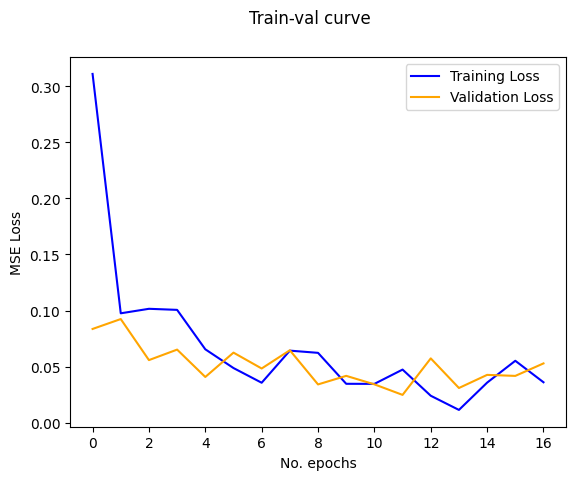

0.014783362282450165
1
1


  0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\kjvf934\repo\ml_challenge\.venv\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Train MSE  0.0932532548904419


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.04447976499795914
2


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.0762881338596344


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.03178311884403229
3


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.0784391462802887


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.024256499484181404
4


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.056257713586091995


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.029212411493062973
5


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.05496382713317871


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.020342757925391197
6


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.05759406089782715


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.01732347160577774
7


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.02974722906947136


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.021210679784417152
8


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.01926545426249504


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.03466133400797844
9


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.03238135948777199


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.02894308976829052
10


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.03833344578742981


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.026595959439873695
11


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.03595134615898132


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.017785856500267982
Early stopping after 11 epochs.
[0.0932532548904419, 0.0762881338596344, 0.0784391462802887, 0.056257713586091995, 0.05496382713317871, 0.05759406089782715, 0.02974722906947136, 0.01926545426249504, 0.03238135948777199, 0.03833344578742981, 0.03595134615898132]
[0.04447976499795914, 0.03178311884403229, 0.024256499484181404, 0.029212411493062973, 0.020342757925391197, 0.01732347160577774, 0.021210679784417152, 0.03466133400797844, 0.02894308976829052, 0.026595959439873695, 0.017785856500267982]


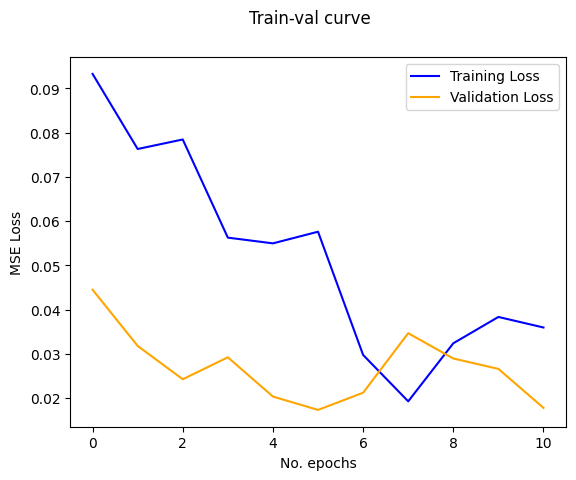

0.015171968970268488
2
1


  0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\kjvf934\repo\ml_challenge\.venv\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Train MSE  0.19519203901290894


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  1.5400009155273438
2


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.3084622621536255


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.33155760169029236
3


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.4433344304561615


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.4551524221897125
4


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.36984726786613464


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.32963985204696655
5


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.2540809214115143


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.12336502969264984
6


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.19407539069652557


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.19716647267341614
7


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.2077920287847519


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.21351225674152374
8


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.24554836750030518


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.14783361554145813
9


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.09403587132692337


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.17322386801242828
10


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.18087534606456757


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.21976777911186218
Early stopping after 10 epochs.
[0.19519203901290894, 0.3084622621536255, 0.4433344304561615, 0.36984726786613464, 0.2540809214115143, 0.19407539069652557, 0.2077920287847519, 0.24554836750030518, 0.09403587132692337, 0.18087534606456757]
[1.5400009155273438, 0.33155760169029236, 0.4551524221897125, 0.32963985204696655, 0.12336502969264984, 0.19716647267341614, 0.21351225674152374, 0.14783361554145813, 0.17322386801242828, 0.21976777911186218]


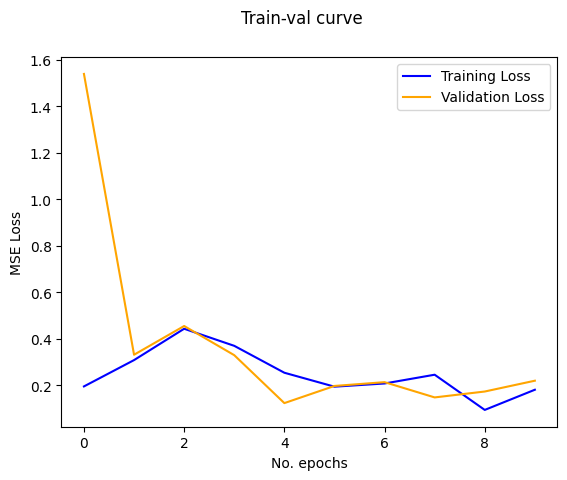

0.14274025830477777
3
1


  0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\kjvf934\repo\ml_challenge\.venv\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Train MSE  0.3094146251678467


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.06498745828866959
2


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.10527124255895615


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.09023437649011612
3


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.06613739579916


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.07057671248912811
4


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.09880604594945908


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.03814822807908058
5


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.06487004458904266


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.06168949231505394
6


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.07344537228345871


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.04953809082508087
7


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.06663989275693893


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.03799865394830704
8


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.05678405612707138


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.04694312438368797
9


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.05558830127120018


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.02403569035232067
10


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.05785202980041504


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.03900889679789543
11


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.02816551737487316


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.04735184833407402
12


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.05678027123212814


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.06495646387338638
13


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.0492607019841671


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.028276080265641212
14


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.03886917978525162


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.030941521748900414
Early stopping after 14 epochs.
[0.3094146251678467, 0.10527124255895615, 0.06613739579916, 0.09880604594945908, 0.06487004458904266, 0.07344537228345871, 0.06663989275693893, 0.05678405612707138, 0.05558830127120018, 0.05785202980041504, 0.02816551737487316, 0.05678027123212814, 0.0492607019841671, 0.03886917978525162]
[0.06498745828866959, 0.09023437649011612, 0.07057671248912811, 0.03814822807908058, 0.06168949231505394, 0.04953809082508087, 0.03799865394830704, 0.04694312438368797, 0.02403569035232067, 0.03900889679789543, 0.04735184833407402, 0.06495646387338638, 0.028276080265641212, 0.030941521748900414]


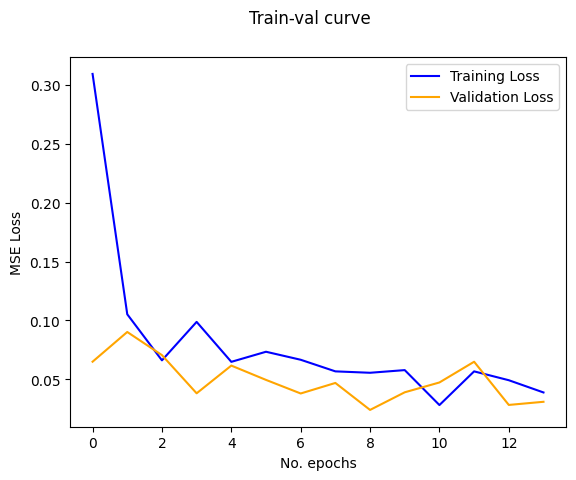

0.020451821721709014
4
1


  0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\kjvf934\repo\ml_challenge\.venv\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Train MSE  0.06901122629642487


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.2144453525543213
2


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.07446236163377762


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.14155182242393494
3


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.1311371922492981


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.11092288047075272
4


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.07479492574930191


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.06734684109687805
5


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.09130537509918213


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.08986541628837585
6


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.0441875122487545


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.10922659933567047
7


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.06463812291622162


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.06185051426291466
8


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.0722515732049942


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.03973512351512909
9


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.05544707551598549


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.06195918098092079
10


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.035833939909935


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.053216319531202316
11


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.07194562256336212


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.07910887897014618
12


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.05153621733188629


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.0534563884139061
13


  0%|          | 0/2 [00:00<?, ?it/s]

Train MSE  0.05711100623011589


  0%|          | 0/1 [00:00<?, ?it/s]

Val MSE  0.07747550308704376
Early stopping after 13 epochs.
[0.06901122629642487, 0.07446236163377762, 0.1311371922492981, 0.07479492574930191, 0.09130537509918213, 0.0441875122487545, 0.06463812291622162, 0.0722515732049942, 0.05544707551598549, 0.035833939909935, 0.07194562256336212, 0.05153621733188629, 0.05711100623011589]
[0.2144453525543213, 0.14155182242393494, 0.11092288047075272, 0.06734684109687805, 0.08986541628837585, 0.10922659933567047, 0.06185051426291466, 0.03973512351512909, 0.06195918098092079, 0.053216319531202316, 0.07910887897014618, 0.0534563884139061, 0.07747550308704376]


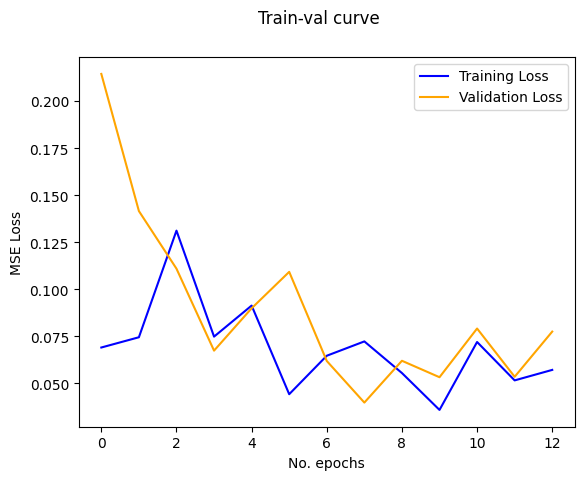

0.03222385880989204
[0.014783362282450165, 0.015171968970268488, 0.14274025830477777, 0.020451821721709014, 0.03222385880989204]
Cross Validation time:  26.634354829788208


In [57]:
#
start = time.time()
train.train_with_cv(train.ThermoNetTrainer,x_train, y_train_norm, cv=5, no_epochs=30, lr=0.001,)
print('Cross Validation time: ', time.time() - start)


The model seems to generalize well, the performance from cross validation is comparable to ridge's (slightly worse in this case) - lets see performance on the test set, if it keeps up

In [58]:
test_dataset = data.SequenceDataset(x_test, y_test_norm)

test_dataloader = DataLoader(test_dataset, batch_size=32)

score=[]
for inputs, labels in tqdm(test_dataloader):
    y_pred = trainer.predict(inputs)
    score.append(mean_squared_error(y_pred, labels))
print(np.mean(score))
print(r2_score(y_pred, labels))

  0%|          | 0/2 [00:00<?, ?it/s]

0.010686542
0.5690525839132601


In [59]:
for i in range(15):
    print(y_pred[i], labels[i])

tensor([0.6012]) tensor([0.5634])
tensor([0.4684]) tensor([0.4190])
tensor([0.8095]) tensor([1.])
tensor([0.5958]) tensor([0.5246])
tensor([0.6452]) tensor([0.6585])
tensor([0.5370]) tensor([0.5352])
tensor([0.6517]) tensor([0.5246])
tensor([0.3290]) tensor([0.3099])
tensor([0.5261]) tensor([0.3345])
tensor([0.8424]) tensor([0.9437])
tensor([0.5601]) tensor([0.6092])
tensor([0.8072]) tensor([0.9965])
tensor([0.5611]) tensor([0.5317])
tensor([0.6436]) tensor([0.5845])
tensor([0.4291]) tensor([0.4577])


The model is slightly overfitting, but it generalizes well for the first try. So far Ridge Regression outperforms our neural networks however we haven't played with optimizing the model (most parameters were chosen arbitrarily). 

However, it is possible that RidgeRegression will be the best performing model for this problem. Next steps would be to do thorough error analysis for all three models, see where model is not performing well and try to figure out why; optimizing the parameters of the neural networks would also be a smart next move. We can also examine how the models perform on eigenvalues obtained from MCA however I will not have enough time to do so (as approximate time limit has passed)

## Conclusions Overall
There is enough data of good enough quality to create a prototype of predictive model for thermostability predictions. At the moment, Ridge Regression seems like the most promising model however neural networks also perform well, so it is very likely that after small optimization, they will outperform Ridge. Furthermore, we only exmained the models on the one-hot encoded data - examining the performance on embeddings would be an important next step, as they are likely to represent sequences better. 

Like in many other ML tasks, in this case it is clear that data preprocessing requires most effort, time and focus. Although one-hot encoding is the most basic approach for this kind of problem (even though it is commonly used), the development of predictive model was quite straightforward. 

## If I had more time

As there is a limited time for this excercise, I took a slightly different approach to then one I usually take - normally I would spend way more time exploring the data, feature engineering etc, while here I tried to do bits of EDA, preprocessing & modelling at once. Nevertheless, there are many different things one could explore in both long-term and short-term:

In short term, I would make sure to try:
* Train embedding models from scratch, using only our data - I imagine this will be the most effective approach for representing embeddings, not very generelizable but good for our purposes
* Do more exploratory work of the obtained embeddings - I only scratched the surface with using pretrained protBert, I could examine differ tokenizing strategies, different pretrained models, and seeing which represent the features best.
* Examine different ways of representing sequences - for example SMILES or different ways of representing sequences as graphs (this could be particularly interesting when dealing with secondary and tertiary str). It would be also beneficial to reduce the no. of features.
* Try more models - so far I only tried linear regression and neural networks, but there is a range of other models which could be useful such as SVMs, Random Forests, XGBoosts etc
* fine-tuning hyperparameters of the model


In the long term, I would also try:
* Examine feature importance & explainability of our model - once we have a good data representation and good model, I could use SHAP or Limes or a different tool to examine feature importance and see which features contribute the most to predictions.  
* Look into feature engineering - although we are mainly interested in the sequences data as presented, we could derive some additional features from it (such as molecular mass of each protein, ratio of different aa per sequence) which we could use for predicting thermostability.
* examine if tools such as AlphaFold could help - currently we are only working with primary sequences but it could be worth to look into secondary/tertiary sequences as well, for that we can use alpha fold


Of course I would also make sure to thoroughly test the code - most of the code snippets used here come from well-tested APIs or I have used in the past & know they work, but thorough unit-testing is essential to prevent catastrophes